<a id='top_of_page'></a>
# GoodDoggo - Wrangling and Assessing 'WeRateDogs' Twitter Data

<a id='top_of_page'></a>
## Table of Contents

- **[Gather](#gather)**
  - [Retrieve Local Data (manually)](#retrieve_local)
  - [Retrieve Image Data from a url (programmatically)](#retrieve_via_url)
  - [Retrieve Twitter Data (via API)](#retrieve_via_API)<br>

- **[Assess](#assess)**
  - [Quality](#assess_quality)
    - [Completeness](#assess_completeness)
    - [Validity](#assess_validity)
    - [Accuracy](#assess_accuracy)
    - [Consistency](#assess_consistency)
  - [Tidiness](#assess_tidiness)<br>
  - [Summary of Initial Observations](#assess_summary_initial)<br>

- **[Clean](#clean)**
  - [Quality](#clean_quality)
    - [Number of records](#clean_num_records)
    - [High numerators](#clean_high_numerator)
    - [High denominators](#clean_high_denominator)
    - [Zero values in numerators and denominators](#clean_numerator_zeros)
    - [Converting columns to type 'datetime'](#clean_datetime)
    - [Converting columns to type 'int64' (archive data)](#clean_int64)
    - [_(No Cleaning)_ Assess Updated Columns](#assess_updated_columns)
    - [Remove retweets](#clean_retweets)
    - [Converting columns to type 'int64' (JSON data)](#clean_int64_JSON_data)  
    - [Remove entries with multiple dog stages](#clean_number_of_dog_stages)
  - [Tidiness](#clean_tidiness)
    - [Remove columns associated with retweets](#clean_retweet_columns)
    - [Combine dog descriptions into a single column](#clean_dog_categories)
    - [Extract urls from 'text' column](#clean_text_urls)
    - [Merge Dataframes](#clean_tables)
    - [Update the Number of Records](#clean_update_records)

- **[Preparation For Analysis](#analysisPrep)**
  - [Feature Engineering](#analysisPrep_feature_engineering)
  - [Save the Dataframes and Create Local Backups](#saveCleanedDataframes)
  - [Create Plotting Functions](#analysisPrep_plotting_functions)

- **[Analysis & Visualizations](#analysis_visualizations)**
  - [Histograms of Favorites](#analysis_histogram_favorites)
  - [Favorites vs. Time](#analysis_favorite_count_vs_time)
  - [Tweets per week](#analysis_tweets_per_week)
  - [Tweets vs. Breed Type](#analysis_tweets_grouped_by_breed)
  
- **[Final List of Issues That Were Defined/Cleaned/Tested](#cleaned_summary_final)**
- **[Potential Future Work](#potential_future_work)**

In [1]:
# for data wrangling and sampling
import pandas as pd
import numpy as np
import random

import requests       # to download files programmatically
import os             # to save/open files and for terminal-like commands to navigate local machine
import tweepy
import pprint as pp   # data pretty printer - https://docs.python.org/2/library/pprint.html
import json           # for json I/O and parsing
import time           # for timing code and dealing with Twitter's rate limit

# Set the random seed to assure the same answers are returned each time 
random.seed(42)

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

# commented out (not needed)
    # # for (potential) regression modeling of data
    # import statsmodels.api as sm;
    # from patsy import dmatrices
    # from statsmodels.stats.outliers_influence import variance_inflation_factor

<a id='gather'></a>
([Top of Page](#top_of_page))
## Gather

<a id='retrieve_local'></a>
([Top of Page](#top_of_page))
### Retrieve Local Data (Read in a Previously Provided Twitter Archive)

In [2]:
df_archive = pd.read_csv("twitter-archive-enhanced.csv")
df_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


<a id='retrieve_via_url'></a>
([Top of Page](#top_of_page))
### Retrieve Image Data from a URL (programmatically)

In [3]:
# get file from a url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

# get the current working directory
folder_name = os.getcwd()

# get the filename
file_name = url.split('/')[-1]

# save the retrieved file to local storage
with open(os.path.join(folder_name,
                      file_name), mode='wb') as file:
    file.write(response.content)

# read in the downloaded file
df_images = pd.read_csv(file_name, sep='\t')
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


NOTE:
* The response variable is in bytes format, not text format.
* As such, the 'wb' flag is used when writing the file locally
* [Link to a StackOverflow post](https://stackoverflow.com/questions/2665866/what-does-wb-mean-in-this-code-using-python) on the subject

<a id='retrieve_via_API'></a>
([Top of Page](#top_of_page))
### Retrieve Twitter Data (via API)

#### Create an API object to gather Twitter data

In [4]:
# get the API Access Token and Acces Token Secret
from twAPI_tokens_GoodDoggo import API_KEY, API_KEY_SECRET, API_TOKEN, API_TOKEN_SECRET

CONSUMER_KEY = API_KEY
CONSUMER_SECRET = API_KEY_SECRET
ACCESS_TOKEN = API_TOKEN
ACCESS_SECRET = API_TOKEN_SECRET

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

# define api object, using arguments to get around (i.e., wait on) the twitter rate limit
api = tweepy.API(auth, 
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

#### Get a list of tweet IDs:

In [5]:
# Check if there are any repeated tweets in the archive
numUniqueValues = df_archive.tweet_id.nunique()
print('Number of tweets: ' + str(len(df_archive)))
print('Number of repeated tweets: ' + str(len(df_archive) - numUniqueValues))

# Create list of tweet IDs
tweet_id_list = df_archive.tweet_id.tolist()

Number of tweets: 2356
Number of repeated tweets: 0


### Use the API to get info for each tweet

* ___Retrieve json data for the first tweet and write it to local storage___
* [StackOverflow article](https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id) on getting JSON data for a specific tweet
* [StackAbuse article](https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/) on reading and writing JSON to a file in Python

In [6]:
print('- Tweet retrieval (for 2356 tweets) took 30 minutes to complete, due to Twitter\'s rate limit.\n' +
      '- As a result, it was performed once, then commented out to allow restarting the kernel / debugging\n' + 
      'the rest of the analysis.')

# loop through multiple tweet_id's, retrieving and writing their json data to 'tweet_json.txt' 
# with open('tweet_json.txt', mode = 'w') as textFile:
#     count = 0
#     for tweet_id in tweet_id_list:
#         count = count + 1
#         start = time.time()
#         try:
#             status = api.get_status(tweet_id)
#             jsonStr = json.dumps(status._json)
#         except:
#             continue     # tweet no longer exists
#         textFile.write(jsonStr + '\n')
#         end = time.time()
#         currTime = str(time.localtime().tm_hour) + ':' + str(time.localtime().tm_min) + ':' + str(time.localtime().tm_sec)
#         print('count: ' + str(count) + ', time elapsed: ' + str(end - start) + ', current time: ' + currTime)

- Tweet retrieval (for 2356 tweets) took 30 minutes to complete, due to Twitter's rate limit.
- As a result, it was performed once, then commented out to allow restarting the kernel / debugging
the rest of the analysis.


__Print first line of 'tweet_json.txt' to check that the above worked__

In [7]:
# print first line of 'tweet_json.txt' to check that the above worked
with open('tweet_json.txt') as jsonFile:
    line = jsonFile.readline()
    tweet = json.loads(line)
    pp.pprint(tweet)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'entities': {'hashtags': [],
              'media': [{'display_url': 'pic.twitter.com/MgUWQ76dJU',
                         'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
                         'id': 892420639486877696,
                         'id_str': '892420639486877696',
                         'indices': [86, 109],
                         'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
                         'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
                         'sizes': {'large': {'h': 528,
                                             'resize': 'fit',
                                             'w': 540},
                                   'medium': {'h': 528,
                                              'resize': 'fit',
                                              'w': 540},
           

**Add the tweet data to a dataframe**

In [8]:
# create a local dataframe for storing tweet data
df_tweetInfo = pd.DataFrame(columns = ['tweet_id', 'retweet_count', 'favorite_count'])

# store tweet data to the dataframe
with open('tweet_json.txt') as jsonFile:
    count = 0
    start = time.time()
    for line in jsonFile:
        count = count + 1
        tweet = json.loads(line)
        df_tweetInfo = df_tweetInfo.append({
            'tweet_id': tweet['id'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']
        }, ignore_index=True)
        end = time.time()
        if (np.remainder(count, 200) == 0):
            currTime = str(time.localtime().tm_hour) + ':' + str(time.localtime().tm_min) + ':' + str(time.localtime().tm_sec)
            print('count: ' + str(count) + ', time elapsed: ' + str(end - start) + ', current time: ' + currTime)
        
# # add a single tweet's data to the dataframe
# df_tweetInfo = df_tweetInfo.append({
#     'tweetID': tweet['id'],
#     'retweet_count': tweet['favorite_count'],
#     'favorite_count': tweet['retweet_count']
# },ignore_index=True)

#tweetInfo.head()

count: 200, time elapsed: 0.2988150119781494, current time: 7:36:3
count: 400, time elapsed: 0.6370489597320557, current time: 7:36:4
count: 600, time elapsed: 0.9441490173339844, current time: 7:36:4
count: 800, time elapsed: 1.2225589752197266, current time: 7:36:4
count: 1000, time elapsed: 1.561661958694458, current time: 7:36:5
count: 1200, time elapsed: 1.8397388458251953, current time: 7:36:5
count: 1400, time elapsed: 2.13828706741333, current time: 7:36:5
count: 1600, time elapsed: 2.4854679107666016, current time: 7:36:6
count: 1800, time elapsed: 2.7821829319000244, current time: 7:36:6
count: 2000, time elapsed: 3.064647912979126, current time: 7:36:6
count: 2200, time elapsed: 3.3735198974609375, current time: 7:36:7


In [9]:
df_tweetInfo.head()
#len(df_tweetInfo)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8159,37468
1,892177421306343426,6039,32198
2,891815181378084864,3997,24271
3,891689557279858688,8304,40780
4,891327558926688256,9007,39001


<a id='assess'></a>
([Top of Page](#top_of_page))
## Assess
Assess the data for Quality and Tidiness. Per Udacity course notes, Quality and Tidiness are defined as follows:

**Quality** issues refers to problems with content, such as missing, duplicate, or incorrect data. Low quality data is sometimes referred to as 'dirty' data. Quality issues generally fall into one of four categories or 'dimensions':
* **Completeness**
  * Have all ___records that should have been obtained___ actually been obtained?
  * Are there any ___missing records___?
  * Are ___specific rows, columns or cells missing___?
  
* **Validity:**
  * Perhaps the records exist, but they're ___not valid___?
    * i.e., they ___don't conform to a defined schema___.
    * A schema is a defined set of rules for data. 
    * These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).
    
* **Accuracy:**
  * Inaccurate data:
    * is ___wrong data that is valid___. 
    * ___adheres to the defined schema, but is still incorrect___
    * Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.
    
* **Consistency:**
  * Inconsistent data is both valid and accurate, but ___there are multiple correct ways of referring to the same thing___.
  * Consistency means the data has a **standard format**. For instance, columns that represent the same data across tables and/or within tables is desired.

**Tidiness** refers to the data's structure. Untidy data has structural issues that can slow down or prevent easy analysis. Untidy data is sometimes referred to as 'messy' data. Traits of tidy data include:
* Each variable forms a column.
* Each observation forms a row.
* Each type of observational unit forms a table.

<a id='assess_quality'></a>
([Top of Page](#top_of_page))
## Assess - Quality
* Assess the data for issues with content, such as missing, duplicate, or incorrect data.
  * Start by briefly viewing the data to get a sense of it.
  * Then assess the data with respect to completeness, validity, accuracy, and consistency

In [10]:
df_tweetInfo.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8159,37468
1,892177421306343426,6039,32198
2,891815181378084864,3997,24271
3,891689557279858688,8304,40780
4,891327558926688256,9007,39001


In [11]:
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [12]:
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='assess_completeness'></a>
([Top of Page](#top_of_page))
### Completeness
* Have all ___records that should have been obtained___ actually been obtained?
* Are there any ___missing records___?
* Are ___specific rows, columns or cells missing___?

In [13]:
print('# of records in df_tweetInfo (i.e., JSON data retrieved via API): ' + str(len(df_tweetInfo)))
print('# of records in df_archive (i.e., weRateDogs Tweet archive):      ' + str(len(df_archive)))
print('# of records in df_images (i.e., image analysis):                 ' + str(len(df_images)))
#tweetInfo.head()

# of records in df_tweetInfo (i.e., JSON data retrieved via API): 2335
# of records in df_archive (i.e., weRateDogs Tweet archive):      2356
# of records in df_images (i.e., image analysis):                 2075


<span style="color:blue">The dataframes have a different number of records.</span>
* The slight difference between df_tweetInfo and df_archive is probably due to tweets that have been deleted
* The difference betweeen df_archive and df_images is probably due to not all tweets having images

In [14]:
print('# of tweet_id\'s in df_images that are also in df_archive: ' + 
     str(len(df_images.tweet_id.isin(df_archive.tweet_id))))
print('# of tweet_id\'s in df_images that are also in df_tweetInfo: ' + 
     str(len(df_images.tweet_id.isin(df_tweetInfo.tweet_id))))

# of tweet_id's in df_images that are also in df_archive: 2075
# of tweet_id's in df_images that are also in df_tweetInfo: 2075


<span style="color:blue">
    Since all tweet_id's in df_images are also in df_archive and df_tweetInfo, the appropriate set to use is the intersection of the three df's.
</span>

<a id='assess_validity'></a>
([Top of Page](#top_of_page))
### Validity
* Perhaps the records exist, but they're ___not valid___?
  * i.e., they ___don't conform to a defined schema___.
  * A schema is a defined set of rules for data. 
  * These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).

In [15]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


<span style="color:blue">
    
<span style="color:black"> Investigate / clean the following issues: </span>
* In **df_archive**, the maximum value for rating_numerator may be unrealistically high.
* In **df_archive**, the maximum value for rating_denominator may be unrealistically high.
* In **df_archive**, the minimum value for rating_numerator probably should not be zero.
* In **df_archive**, the minimum value for rating_denominator should not be zero.
</span>

#### Check other dataframes for any obvious validity issues

In [16]:
df_images.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [17]:
df_tweetInfo.describe()

,tweet_id,retweet_count,favorite_count
count,2335,2335,2335
unique,2335,1712,1979
top,667495797102141441,88,0
freq,1,5,165


In [18]:
df_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [19]:
df_archive.groupby('rating_numerator').rating_numerator.count()

rating_numerator
0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

<span style="color:blue">

In **df_archive**, some **rating_numerator** values are quite large. Investigate whether this is an issue / consider removing numerators over a certain threshold.

</span>

In [20]:
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [21]:
searchString = 'NaN'
df_archive.query("in_reply_to_status_id != 'NaN'").head(2)

# # example syntax
# #df_images.query('p1_conf > 0.2').head()
# searchString = 'German_shepherd'
# df_images.query("p1 != @searchString").head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None


In [22]:
df_tweetInfo.nunique()

tweet_id          2335
retweet_count     1712
favorite_count    1979
dtype: int64

In [23]:
df_images.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

<span style="color:blue">

In **df_images**, the number of jpg_urls does not match the number of tweet_id's. Investigate whether this is an issue. If so, correct it.

</span>

Explore dog stages

In [24]:
df_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [25]:
print(str(df_archive.groupby('doggo').doggo.count()) + '\n---------------------------------' )
print(str(df_archive.groupby('floofer').floofer.count()) + '\n---------------------------------' )
print(str(df_archive.groupby('pupper').pupper.count()) + '\n---------------------------------' )
print(str(df_archive.groupby('puppo').puppo.count()) + '\n---------------------------------' )
print(df_archive.shape)
# df_archive.groupby('rating_numerator').rating_numerator.count()
# ## Make sure all tweets have only one dog stage
# 
# ## Add a 'none' column for tweets that do not have a dog stage

doggo
None     2259
doggo      97
Name: doggo, dtype: int64
---------------------------------
floofer
None       2346
floofer      10
Name: floofer, dtype: int64
---------------------------------
pupper
None      2099
pupper     257
Name: pupper, dtype: int64
---------------------------------
puppo
None     2326
puppo      30
Name: puppo, dtype: int64
---------------------------------
(2356, 17)


<span style="color:blue">

* In **df_archive**, add a 'none' category for tweets that do not have a dog stage
* In **df_archive**, make sure all tweets have only one dog stage

</span>

<a id='assess_accuracy'></a>
([Top of Page](#top_of_page))
### Accuracy
* Inaccurate data:
  * is ___wrong data that is valid___. 
  * ___adheres to the defined schema, but is still incorrect___
  * Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.

In [26]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [27]:
df_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [28]:
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [29]:
df_tweetInfo.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8159,37468
1,892177421306343426,6039,32198
2,891815181378084864,3997,24271
3,891689557279858688,8304,40780
4,891327558926688256,9007,39001


#### There do not appear to be any obvious accuracy issues

<a id='assess_consistency'></a>
([Top of Page](#top_of_page))
### Consistency
* Inconsistent data is both valid and accurate, but _there are multiple __correct__ ways of referring to the same thing_.
* Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

In [30]:
print(df_tweetInfo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
tweet_id          2335 non-null object
retweet_count     2335 non-null object
favorite_count    2335 non-null object
dtypes: object(3)
memory usage: 54.8+ KB
None


In [31]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<span style="color:blue">

* In **df_archive**, 'timestamp' and 'retweeted_status_timestamp' should have type 'datetime'.
* In **df_archive**, the following columns should have type 'int64':
   * 'in_reply_to_status_id'
   * 'in_reply_to_user_id',
   * 'retweeted_status_id'
   * 'retweeted_status_user_id'

</span>

In [32]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [33]:
df_tweetInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
tweet_id          2335 non-null object
retweet_count     2335 non-null object
favorite_count    2335 non-null object
dtypes: object(3)
memory usage: 54.8+ KB


<span style="color:blue">

In **df_tweetInfo**, 'tweet_id' should have type 'int64' for consistency across the dataframes.

</span>

<a id='assess_tidiness'></a>
([Top of Page](#top_of_page))

## Assess - Tidiness
Tidiness refers to the data's structure. Untidy data has structural issues that can slow down or prevent easy analysis. Untidy data is sometimes referred to as 'messy' data. Traits of tidy data include:
* Each variable forms a column.
* Each observation forms a row.
* Each type of observational unit forms a table.

### Preview the Dataframes Again (Looking for Tidiness Issues This Time)

In [34]:
df_tweetInfo.head(2)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8159,37468
1,892177421306343426,6039,32198


In [35]:
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


<span style="color:blue">
    
* 'doggo', 'floofer', 'pupper', and 'puppo' are categories and should be **combined into a single column**. 
<span style="color:black">
    
  * Consider the possibility of tweets that fall into multiple such categories.
<span>
</span>

#### Preview 'text' entries since they do not fit in the default dataframe column width.

In [36]:
df_archive.text[0:5].apply(lambda x: print('- ' + x))

- This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
- This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
- This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
- This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
- This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f


0    None
1    None
2    None
3    None
4    None
Name: text, dtype: object

<span style="color:blue">

* In df_archive, **urls should be extracted from the 'text' column**
<span style="color:black">
    
<span>
</span>

In [37]:
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<span style="color:blue">

* **df_tweetInfo** and **df_archive** should be merged into one dataframe.
<span style="color:black">
    
  * Combine them on 'tweet_id'
<span>
</span>

<a id='assess_summary_initial'></a>
([Top of Page](#top_of_page))

## Summary of Initial Observations
<span style="color:blue">
    
  <br>**Upon the initial data assessement, the following quality and tidiness issues were observed:**

</span>

* **Quality:**
  * **The dataframes have a different number of records.**
    * The slight difference between df_tweetInfo and df_archive is probably due to tweets that have been deleted
    * The difference betweeen df_archive and df_images is probably due to not all tweets having images
    * Since all tweet_id's in df_images are also in df_archive and df_tweetInfo, the appropriate set to use is the intersection of the three df's.
  * In **df_archive**, the maximum value for rating_numerator may be unrealistically high.
  * In **df_archive**, the maximum value for rating_denominator may be unrealistically high.
  * In **df_archive**, the minimum value for rating_numerator probably should not be zero.
  * In **df_archive**, the minimum value for rating_denominator should not be zero.
  * In **df_archive**, some **rating_numerator** values are quite large. Investigate whether this is an issue / consider removing numerators over a certain threshold.
  * In **df_images**, the number of jpg_urls does not match the number of tweet_id's. Investigate whether this is an issue. If so, correct it.
  * In **df_archive**, add a 'none' category for tweets that do not have a dog stage
  * In **df_archive**, make sure all tweets have only one dog stage
  * In **df_archive**, 'timestamp' and 'retweeted_status_timestamp' should have type 'datetime'.
    * Likely code to use:
      * <code>df_archive\['timestamp'\] = pd.to_datetime(df_archive\['timestamp'\])</code>
      * <code>df_archive\['retweeted_status_timestamp'\] = pd.to_datetime(df_archive\['retweeted_status_timestamp'\])</code>
  * In **df_archive**, the following columns should have type 'int64':
    * 'in_reply_to_status_id'
    * 'in_reply_to_user_id',
    * 'retweeted_status_id'
    * 'retweeted_status_user_id'
  * In **df_tweetInfo**, 'tweet_id' should have type 'int64' for consistency across the dataframes.<br><br>

* **Tidiness:**
  * 'doggo', 'floofer', 'pupper', and 'puppo' are categories and should be **combined into a single column**. 
  * In df_archive, **urls should be extracted from the 'text' column**
  * **df_tweetInfo** and **df_images** should be merged into one dataframe.
    * Combine them on 'tweet_id'

<a id='clean'></a>
([Top of Page](#top_of_page))
## Clean
Clean the data issues observed in the "Assess" phase. Every issue that is cleaned should go through the following process:
* **Define**:
  * Define the issue and convert any assessments into "how-to" guides
  * This is essentially pseudo-code
  * This serves as future documentation for myself and for others

* **Code**:
  * Translate words from the 'Define' step to code

* **Test**:
  * Test the dataset(s) to make sure the cleaning code worked
  * This is kind of like re-visiting the "Assess" phase<br>
  
**Begin the cleaning phase by backing up the existing datasets:**

In [38]:
df_archive_orig = df_archive.copy(deep=True)
df_images_orig = df_images.copy(deep=True)
df_tweetInfo_orig = df_tweetInfo.copy(deep=True)

<a id='clean_quality'></a>
([Top of Page](#top_of_page))
## Clean - Quality

<a id='clean_num_records'></a>
([Top of Page](#top_of_page))
### Define
**The dataframes have a different number of records.**
* The slight difference between df_tweetInfo and df_archive is probably due to tweets that have been deleted
* The difference betweeen df_archive and df_images is probably due to not all tweets having images
* Since all tweet_id's in df_images are also in df_archive and df_tweetInfo, the appropriate set to use is the intersection of the three df's.<br>
  
**Pseudo-code:**
* Create a list of tweet_ids for each dataframe
* Keep the tweet_ids that are common to all three lists
* Using that list of tweet_ids, reassign the dataframes

### Code

In [39]:
# Create a list of tweet_ids for each dataframe:
tweet_ids_archive = df_archive_orig['tweet_id'].tolist()
tweet_ids_images = df_images_orig['tweet_id'].tolist()
tweet_ids_API = df_tweetInfo_orig['tweet_id'].tolist()

# Keep the tweet_ids that are common to all three lists:
tweet_ids_to_keep = list(set(tweet_ids_archive).intersection(tweet_ids_API).intersection(tweet_ids_images))

# Using that list of tweet_ids, reassign the dataframes:
df_archive = df_archive_orig[df_archive_orig.tweet_id.isin(tweet_ids_to_keep)]
df_images = df_images_orig[df_images_orig.tweet_id.isin(tweet_ids_to_keep)]
df_tweetInfo = df_tweetInfo_orig[df_tweetInfo_orig.tweet_id.isin(tweet_ids_to_keep)]

### Test

In [40]:
print('# of records in df_tweetInfo (i.e., JSON data retrieved via API): ' + str(len(df_tweetInfo)))
print('# of records in df_archive (i.e., weRateDogs Tweet archive):      ' + str(len(df_archive)))
print('# of records in df_images (i.e., image analysis):                 ' + str(len(df_images)))

# of records in df_tweetInfo (i.e., JSON data retrieved via API): 2063
# of records in df_archive (i.e., weRateDogs Tweet archive):      2063
# of records in df_images (i.e., image analysis):                 2063


<a id='clean_high_numerator'></a>
([Top of Page](#top_of_page))
### Define
**In df_archive, the maximum value for rating_numerator may be unrealistically high.**

**Pseudo-code:**
* Investigate ratings with high rating_numerator values
* Drop any rows with incorrect numerator values
  * NOTE: high numerators are acceptable (they're good dogs). Only drop numerators that are incorrect.

### Code

In [41]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.063000e+03,2.300000e+01,2.300000e+01,7.400000e+01,7.400000e+01,2063.000000,2063.000000
mean,7.379294e+17,6.978112e+17,4.196984e+09,7.619394e+17,1.064138e+16,12.262724,10.514300
std,6.756579e+16,4.359384e+16,0.000000e+00,5.800000e+16,9.154057e+16,40.798407,7.197819
min,6.660209e+17,6.671522e+17,4.196984e+09,6.675094e+17,7.832140e+05,0.000000,2.000000
25%,6.763473e+17,6.732411e+17,4.196984e+09,7.117707e+17,4.196984e+09,10.000000,10.000000
50%,7.116527e+17,6.757073e+17,4.196984e+09,7.755992e+17,4.196984e+09,11.000000,10.000000
75%,7.928986e+17,7.031489e+17,4.196984e+09,7.958815e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.558181e+17,4.196984e+09,8.768508e+17,7.874618e+17,1776.000000,170.000000


Perform a 'groupby' on rating_numerator to get a better sense of its distribution

In [42]:
df_archive.groupby('rating_numerator').rating_numerator.count()

rating_numerator
0         2
1         5
2         9
3        19
4        16
5        34
6        32
7        52
8        95
9       151
10      428
11      413
12      473
13      276
14       38
15        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
204       1
420       1
1776      1
Name: rating_numerator, dtype: int64

Print tweets with high numerator values to better understand what is going on

In [43]:
# get indices for tweets with numerator >= 15
high_numerator_indices = set()
for i in df_archive.index:
    if df_archive.loc[i].rating_numerator >= 15:
        high_numerator_indices.add(i)

# print info for tweets with numerator >= 15        
for i in high_numerator_indices:
    print(str(i) + 
          ', tweet_id=' + str(df_archive.tweet_id[i]) + 
          ', rating=' + str(df_archive.rating_numerator[i]) + 
          ', text: ' + str(df_archive.loc[i].text))

516, tweet_id=810984652412424192, rating=24, text: Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
902, tweet_id=758467244762497024, rating=165, text: Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1433, tweet_id=697463031882764288, rating=44, text: Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
2074, tweet_id=670842764863651840, rating=420, text: After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY
285, tweet_id=838916489579200512, rating=15, text: RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI
1712, tweet_id=680494726643068929, rating=26, text: Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
433, tweet_id=820690176645140481, rating=84, text: The floofs ha

High ratings are acceptable (after all: they're good dogs Brent). We only need to remove **incorrect** rating_numerator values. _NOTE: Tweets with incorrector numerator/denominator pairs will be addressed later._
* Only one index has an incorrect rating_numerator value. This index will be removed:
  * 516 (tweet_id = 810984652412424192, rating = 24, text: "24/7")<br><br>

* The following indices have a rating_numerator value that needs corrected. These will be rounded **up** since they're all good dogs:
  * 1712 (tweet_id = 680494726643068929, rating = 26, text: "11.26/10" --> change rating to 12)
  * 695 (tweet_id = 786709082849828864, rating = 75, text: "9.75/10" --> change rating to 10)
  * 763 (tweet_id = 778027034220126208, rating = 27, text: "11.27/10" --> change rating to 12)

In [44]:
# drop tweet_id 810984652412424192 from each of the df's
df_archive = df_archive[df_archive.tweet_id != 810984652412424192]
df_images = df_images[df_images.tweet_id != 810984652412424192]
df_tweetInfo = df_tweetInfo[df_tweetInfo.tweet_id != 810984652412424192]

# reset the index for each df
df_archive.reset_index(drop=True,inplace=True)
df_images.reset_index(drop=True,inplace=True)
df_tweetInfo.reset_index(drop=True,inplace=True)

### Test

In [45]:
print('# of records in df_tweetInfo (i.e., JSON data retrieved via API): ' + str(len(df_tweetInfo)))
print('# of records in df_archive (i.e., weRateDogs Tweet archive):      ' + str(len(df_archive)))
print('# of records in df_images (i.e., image analysis):                 ' + str(len(df_images)))

# of records in df_tweetInfo (i.e., JSON data retrieved via API): 2062
# of records in df_archive (i.e., weRateDogs Tweet archive):      2062
# of records in df_images (i.e., image analysis):                 2062


* The number of tweets has decreased by one in each dataframe
* Check to make sure the correct tweet was removed (check for existence of tweet_id 810984652412424192):

In [46]:
df_archive[df_archive.tweet_id == 810984652412424192]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<br>tweet_id 810984652412424192 no longer exists

<a id='clean_high_denominator'></a>
([Top of Page](#top_of_page))
### Define
* **In df_archive, the maximum value for rating_denominator may be unrealistically high.**<br><br>

* **Pseudo-code:**
  * Check for high denominators
    * If appropriate, remove rows
    * If appropriate, change rating_numerator and rating_denominator

### Code

In [47]:
df_archive.groupby('rating_denominator').rating_denominator.count()

rating_denominator
2         1
10     2045
11        2
20        1
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

Print tweets with denominator != 10 to better understand what is going on

In [48]:
# get indices for tweets with denominator != 10
non_standard_denominator_indices = set()
for i in df_archive.index:
    if df_archive.loc[i].rating_denominator != 10:
        non_standard_denominator_indices.add(i)

# print info for tweets with denominator != 10
for i in non_standard_denominator_indices:
    #print(str(i) + ' - ' + str(df_archive.loc[i].text))
    print(str(i) + 
          ', tweet_id=' + str(df_archive.tweet_id[i]) + 
          ', numerator=' + str(df_archive.rating_numerator[i]) + 
          ', denominator=' + str(df_archive.rating_denominator[i]) + 
          ', text: ' + str(df_archive.loc[i].text) + '\n')

1501, tweet_id=677716515794329600, numerator=144, denominator=120, text: IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq

1121, tweet_id=704054845121142784, numerator=60, denominator=50, text: Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa

866, tweet_id=740373189193256964, numerator=9, denominator=11, text: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ

1037, tweet_id=710658690886586372, numerator=80, denominator=80, text: Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12

1197, tweet_id=697463031882764288, numerator=44, denominator=40, text: Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ

337, tweet_id=820690176645140481, numerator=84, denominator=70, text: The floofs have been released I repeat the floofs have been released. 84/

* Most of the tweets with denominator != 10 have been parsed correctly
* However, some tweets have multiple fractions in the tweet text and the wrong fraction was grabbed when ratings were parsed
  * Such tweets need both their numerator and denominator changed
  * Since there are not very many of them, they will be changed semi-manually
  * If there were more such entries (say, more than 10), then it would make more sense to write code that correctly parses the tweet text with respect to rating
* Indices with incorrect numerator and denominator pairs:
  * 866 (tweet_id = 740373189193256964) 
    * numer = 9, should be 14
    * denom = 11, should be 10
  * 1395 (tweet_id = 682962037429899265)
    * numer = 7, should be 10
    * denom = 11, should be 10
  * 2041 (tweet_id = 666287406224695296)
    * numer = 1, should be 9
    * denom = 2, should be 10
  * 957 (tweet_id = 722974582966214656)
    * numer = 4, should be 13
    * denom = 20, should be 10
  * 991 (tweet_id = 716439118184652801)
    * numer = 50, should be 11
    * denom = 50, should be 10
* Based on the above, create a dataframe of tweet info that needs modified

In [49]:
tweets_to_mod = {'tweet_id': [740373189193256964, 682962037429899265, 666287406224695296, 722974582966214656, 716439118184652801], 
        'numerator_old': [9, 7, 1, 4, 50], 
        'denominator_old': [11, 11, 2, 20, 50],
        'numerator_new': [14, 10, 9, 13, 11], 
        'denominator_new': [10, 10, 10, 10, 10]}
df_tweets_to_mod = pd.DataFrame(tweets_to_mod, columns = ['tweet_id',
                                                          'numerator_old',
                                                          'denominator_old',
                                                          'numerator_new',
                                                          'denominator_new'])
df_tweets_to_mod = df_tweets_to_mod.set_index('tweet_id')

Modify the tweet info

In [50]:
df_archive = df_archive.set_index('tweet_id')
for tweet in df_tweets_to_mod.index.tolist():
    df_archive.loc[tweet,'rating_numerator'] = df_tweets_to_mod.loc[tweet,'numerator_new']
    df_archive.loc[tweet,'rating_denominator'] = df_tweets_to_mod.loc[tweet,'denominator_new']

### Test

In [51]:
for tweet in df_tweets_to_mod.index.tolist():
    rating_old = str(df_tweets_to_mod.loc[tweet,'numerator_old']) + '/' + str(df_tweets_to_mod.loc[tweet,'denominator_old'])
    rating_new = str(df_archive.loc[tweet,'rating_numerator']) + '/' + str(df_archive.loc[tweet,'rating_denominator'])
    print('old ratings: ' + rating_old + ', new ratings: ' + rating_new)    

old ratings: 9/11, new ratings: 14/10
old ratings: 7/11, new ratings: 10/10
old ratings: 1/2, new ratings: 9/10
old ratings: 4/20, new ratings: 13/10
old ratings: 50/50, new ratings: 11/10


<a id='clean_numerator_zeros'></a>
([Top of Page](#top_of_page))
### Define
**Multiple Issues:**
* In **df_archive**, the minimum value for rating_numerator probably should not be zero.
* In **df_archive**, the minimum value for rating_denominator should not be zero.

**Pseudo-code:**
* **check for rating_numerator == 0**
  * Follow previous processes
* **check for rating_denominator == 0**
  * Either remove these or assign a denominator of 10

### Code

In [52]:
df_archive.groupby('rating_numerator').rating_numerator.count()

rating_numerator
0         2
1         4
2         9
3        19
4        15
5        34
6        32
7        51
8        95
9       151
10      429
11      414
12      473
13      277
14       39
15        1
26        1
27        1
44        1
45        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
204       1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [53]:
df_archive.groupby('rating_denominator').rating_denominator.count()

rating_denominator
10     2050
40        1
50        2
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

* There are no longer any tweets with a denominator of 0
  * Such tweets were probably removed when the number of records in the dataframes [were corrected](#clean_num_records)

* Howerver, there are still numerators with a value of 0
  * Since there are only two such values, they will be explored and/or corrected in a semi-manual manner.

In [54]:
# get indices for tweets with numerator == 0
indices_to_check = set()
for i in df_archive.index:
    if df_archive.loc[i].rating_numerator == 0:
        indices_to_check.add(i)

# print info for tweets with numerator == 0
for i in indices_to_check:
    print('tweet_id=' + str(i) + 
          ', numerator=' + str(df_archive.rating_numerator[i]) + 
          ', denominator=' + str(df_archive.rating_denominator[i]) + 
          ', text: ' + str(df_archive.loc[i].text) + '\n')

tweet_id=746906459439529985, numerator=0, denominator=10, text: PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX

tweet_id=835152434251116546, numerator=0, denominator=10, text: When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag



* Tweet 746906459439529985 does not contain any dog images and can be removed
* Tweet 835152434251116546 is a retweet and can be removed
  * Since it utilizes a screenshot of a separate tweet, the fact that it is a retweet is only obvious once once one clicks the url

NOTE: Link on [handling exceptions](https://wiki.python.org/moin/HandlingExceptions) in Python

In [55]:
# drop tweet_id's 746906459439529985 and 835152434251116546
#   - use try/except blocks for debugging purposes
#   - should normally be written as a function, but since there are only 2 such entries, this is quicker / easier
# --------------------------------------------------------------------------------
# tweet 1
try:
    df_archive = df_archive.drop(746906459439529985)
except KeyError:
    print('received a KeyError, meaning the tweet was already dropped from df_archive')

# tweet 2
try:
    df_archive = df_archive.drop(835152434251116546)
except KeyError:
    print('received a KeyError, meaning the tweet was already dropped from df_archive')

### Test

In [56]:
#   - use try/except blocks for debugging purposes
#   - should normally be written as a function, but since there are only 2 such entries, this is quicker / easier
# --------------------------------------------------------------------------------
# tweet 1
try:
    print(df_archive.loc[746906459439529985])
except KeyError:
    print('received a KeyError, meaning the tweet was successfully dropped from df_archive')

# tweet 2
try:
    print(df_archive.loc[746906459439529985])
except KeyError:
    print('received a KeyError, meaning the tweet was successfully dropped from df_archive')

received a KeyError, meaning the tweet was successfully dropped from df_archive
received a KeyError, meaning the tweet was successfully dropped from df_archive


<a id='clean_datetime'></a>
([Top of Page](#top_of_page))
### Define
* In **df_archive**, 'timestamp' and 'retweeted_status_timestamp' should have type 'datetime'.


* Likely code to use:
  * <code>df_archive\['timestamp'\] = pd.to_datetime(df_archive\['timestamp'\])</code>
  * <code>df_archive\['retweeted_status_timestamp'\] = pd.to_datetime(df_archive\

### Code

In [57]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
in_reply_to_status_id         22 non-null float64
in_reply_to_user_id           22 non-null float64
timestamp                     2060 non-null object
source                        2060 non-null object
text                          2060 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2060 non-null object
rating_numerator              2060 non-null int64
rating_denominator            2060 non-null int64
name                          2060 non-null object
doggo                         2060 non-null object
floofer                       2060 non-null object
pupper                        2060 non-null object
puppo                         2060 non-null object
dtypes: float64(4), int64(2), object(10)
memory usage:

In [58]:
df_archive['timestamp'] = pd.to_datetime(df_archive['timestamp'])
df_archive['retweeted_status_timestamp'] = pd.to_datetime(df_archive['retweeted_status_timestamp'])

### Test

In [59]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
in_reply_to_status_id         22 non-null float64
in_reply_to_user_id           22 non-null float64
timestamp                     2060 non-null datetime64[ns, UTC]
source                        2060 non-null object
text                          2060 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null datetime64[ns, UTC]
expanded_urls                 2060 non-null object
rating_numerator              2060 non-null int64
rating_denominator            2060 non-null int64
name                          2060 non-null object
doggo                         2060 non-null object
floofer                       2060 non-null object
pupper                        2060 non-null object
puppo                         2060 non-null object
dtypes: datetime64[ns, UTC](

The 'timestamp' and 'retweeted_status_timestamp' columns both have type 'datetime'

<a id='clean_int64'></a>
([Top of Page](#top_of_page))
### Define
* In **df_archive**, the following columns should have type 'int64':
  * 'in_reply_to_status_id'
  * 'in_reply_to_user_id',
  * 'retweeted_status_id'
  * 'retweeted_status_user_id'

### Code

In [60]:
df_archive['in_reply_to_status_id'] = df_archive['in_reply_to_status_id'].fillna(0).astype(np.int64)
df_archive['in_reply_to_user_id'] = df_archive['in_reply_to_user_id'].fillna(0).astype(np.int64)
df_archive['retweeted_status_id'] = df_archive['retweeted_status_id'].fillna(0).astype(np.int64)
df_archive['retweeted_status_user_id'] = df_archive['retweeted_status_user_id'].fillna(0).astype(np.int64)

### Test

In [61]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
in_reply_to_status_id         2060 non-null int64
in_reply_to_user_id           2060 non-null int64
timestamp                     2060 non-null datetime64[ns, UTC]
source                        2060 non-null object
text                          2060 non-null object
retweeted_status_id           2060 non-null int64
retweeted_status_user_id      2060 non-null int64
retweeted_status_timestamp    74 non-null datetime64[ns, UTC]
expanded_urls                 2060 non-null object
rating_numerator              2060 non-null int64
rating_denominator            2060 non-null int64
name                          2060 non-null object
doggo                         2060 non-null object
floofer                       2060 non-null object
pupper                        2060 non-null object
puppo                         2060 non-null object
dtypes: datetime64[ns, UTC](

Each of the desired columns now has type 'datetime'

<a id='assess_updated_columns'></a>
([Top of Page](#top_of_page))
### _(No Cleaning)_ Assess Updated Columns

* Upon changing these columns to 'int64', it became apparent that they were not adequately explored in the 'Assess' phase
  * 'in_reply_to_status_id'
  * 'in_reply_to_user_id',
  * 'retweeted_status_id'
  * 'retweeted_status_user_id
* The goals of this analysis are to only analyze original tweets, not retweets
* As such, some of the entries represented by these columns can probably be removed
* Explore whether any info in these columns indicates invalid tweets (i.e., retweets)<br><br>
    
* **Start (the "re-assessment") by exploring 'retweeted_status_id'**

In [62]:
df_temp_archive = df_archive[df_archive['retweeted_status_id'] != 0]
#df_temp_archive = df_temp_archive[~df_archive['in_reply_to_status_id'].isnull()]
df_temp_archive.tail(2)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
667550904950915073,0,0,2015-11-20 03:51:52+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,667548695664070656,4296831739,2015-11-20 03:43:06+00:00,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None
667550882905632768,0,0,2015-11-20 03:51:47+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Unoriginal idea. Blatant ...,667548415174144000,4296831739,2015-11-20 03:41:59+00:00,https://twitter.com/dogratingrating/status/667...,5,10,None,None,None,None,None


In [63]:
#https://twitter.com/dog_rates/status/671561002136281088
print(df_temp_archive.loc[667550904950915073].in_reply_to_status_id)
print(df_temp_archive.loc[667550904950915073].in_reply_to_user_id)
print(df_temp_archive.loc[667550904950915073].retweeted_status_id)
print(df_temp_archive.loc[667550904950915073].retweeted_status_user_id)
print(df_temp_archive.loc[667550904950915073].text)
print(df_temp_archive.loc[667550904950915073].expanded_urls)
print('---------------------------------------------------------------------------------')
print(df_temp_archive.loc[667550882905632768].in_reply_to_status_id)
print(df_temp_archive.loc[667550882905632768].in_reply_to_user_id)
print(df_temp_archive.loc[667550882905632768].retweeted_status_id)
print(df_temp_archive.loc[667550882905632768].retweeted_status_user_id)
print(df_temp_archive.loc[667550882905632768].text)
print(df_temp_archive.loc[667550882905632768].expanded_urls)

0
0
667548695664070656
4296831739
RT @dogratingrating: Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10 https://t.co/uarnTjBeVA
https://twitter.com/dogratingrating/status/667548695664070656/photo/1,https://twitter.com/dogratingrating/status/667548695664070656/photo/1
---------------------------------------------------------------------------------
0
0
667548415174144000
4296831739
RT @dogratingrating: Unoriginal idea. Blatant plagiarism. Curious grammar. -5/10 https://t.co/r7XzeQZWzb
https://twitter.com/dogratingrating/status/667548415174144001/photo/1,https://twitter.com/dogratingrating/status/667548415174144001/photo/1


* Tweets with 'retweeted_status_id' != 0 are actually retweets.

<span style="color:blue">

* Since we only want original tweets in our final data set, **tweets with 'retweeted_status_id' != 0 should be removed.**
</span>

  * Once those tweets have been removed, the remaining values for 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' will all be zero or null.

<span style="color:blue">

* Therefore, after retweets have been removed, **columns 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' should be dropped**
</span>

**Now explore 'in_reply_to_status_id'**

In [64]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
in_reply_to_status_id         2060 non-null int64
in_reply_to_user_id           2060 non-null int64
timestamp                     2060 non-null datetime64[ns, UTC]
source                        2060 non-null object
text                          2060 non-null object
retweeted_status_id           2060 non-null int64
retweeted_status_user_id      2060 non-null int64
retweeted_status_timestamp    74 non-null datetime64[ns, UTC]
expanded_urls                 2060 non-null object
rating_numerator              2060 non-null int64
rating_denominator            2060 non-null int64
name                          2060 non-null object
doggo                         2060 non-null object
floofer                       2060 non-null object
pupper                        2060 non-null object
puppo                         2060 non-null object
dtypes: datetime64[ns, UTC](

In [65]:
df_temp_archive = df_archive[df_archive['in_reply_to_status_id'] != 0]
df_temp_archive.tail(2)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
671729906628341761,671561002136281088,4196983835,2015-12-01 16:37:44+00:00,"<a href=""http://twitter.com/download/iphone"" r...",I'm just going to leave this one here as well....,0,0,NaT,https://twitter.com/dog_rates/status/671729906...,13,10,None,None,None,None,None
669353438988365824,667806454573760512,4196983835,2015-11-25 03:14:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,0,0,NaT,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None


In [66]:
print(df_temp_archive.loc[671729906628341761].in_reply_to_status_id)
print(df_temp_archive.loc[671729906628341761].in_reply_to_user_id)
print(df_temp_archive.loc[671729906628341761].retweeted_status_id)
print(df_temp_archive.loc[671729906628341761].retweeted_status_user_id)
print(df_temp_archive.loc[671729906628341761].text)
print(df_temp_archive.loc[671729906628341761].expanded_urls)
print('---------------------------------------------------------------------------------')
print(df_temp_archive.loc[669353438988365824].in_reply_to_status_id)
print(df_temp_archive.loc[669353438988365824].in_reply_to_user_id)
print(df_temp_archive.loc[669353438988365824].retweeted_status_id)
print(df_temp_archive.loc[669353438988365824].retweeted_status_user_id)
print(df_temp_archive.loc[669353438988365824].text)
print(df_temp_archive.loc[669353438988365824].expanded_urls)

671561002136281088
4196983835
0
0
I'm just going to leave this one here as well. 13/10 https://t.co/DaD5SyajWt
https://twitter.com/dog_rates/status/671729906628341761/photo/1
---------------------------------------------------------------------------------
667806454573760512
4196983835
0
0
This is Tessa. She is also very pleased after finally meeting her biological father. 10/10 https://t.co/qDS1aCqppv
https://twitter.com/dog_rates/status/669353438988365824/photo/1


In [67]:
df_temp_archive.groupby('in_reply_to_user_id').in_reply_to_user_id.count()

in_reply_to_user_id
4196983835    22
Name: in_reply_to_user_id, dtype: int64

* Tweets with 'in_reply_to_user_id' != 0 are tweets where the WeRateDogs account has replied to one of its own tweets with a new image, rating, etc.
* Since these tweets contain a new dog image and rating, they are valid to keep

<a id='clean_retweets'></a>
([Top of Page](#top_of_page))
### Define
tweets with 'retweeted_status_id' != 0 should be removed, since they are retweets and we only want original tweets for this analysis

### Code

In [68]:
# current metrics
print('current # of tweets:   ' + str(df_archive.text.count()))
print('current # of retweets: ' + str(df_archive[df_archive['retweeted_status_id'] != 0].retweeted_status_id.count()))

current # of tweets:   2060
current # of retweets: 74


In [69]:
df_archive = df_archive[df_archive['retweeted_status_id'] == 0]

### Test

In [70]:
# updated metrics
print('current # of tweets:   ' + str(df_archive.text.count()))
print('current # of retweets: ' + str(df_archive[df_archive['retweeted_status_id'] != 0].retweeted_status_id.count()))

current # of tweets:   1986
current # of retweets: 0


The 74 retweets have been successfully removed

<a id='clean_int64_JSON_data'></a>
([Top of Page](#top_of_page))
### Define
* In **df_tweetInfo**, 'tweet_id' should have type 'int64' for consistency across the dataframes.

### Code

In [71]:
df_tweetInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 3 columns):
tweet_id          2062 non-null object
retweet_count     2062 non-null object
favorite_count    2062 non-null object
dtypes: object(3)
memory usage: 48.4+ KB


In [72]:
df_tweetInfo['tweet_id'] = df_tweetInfo['tweet_id'].astype(np.int64)

### Test

In [73]:
df_tweetInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 3 columns):
tweet_id          2062 non-null int64
retweet_count     2062 non-null object
favorite_count    2062 non-null object
dtypes: int64(1), object(2)
memory usage: 48.4+ KB


In [74]:
df_tweetInfo.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8159,37468
1,892177421306343426,6039,32198
2,891815181378084864,3997,24271
3,891689557279858688,8304,40780
4,891327558926688256,9007,39001


<a id='clean_number_of_dog_stages'></a>
([Top of Page](#top_of_page))
### Define

* Add a 'none' column to **df_archive** for tweets that do not have a dog stage
* In **df_archive**, make sure all tweets have only one dog stage

### Code

In [75]:
#df_temp_archive = df_archive.copy(deep=True)

# replace stage entries with 1's and 0's
df_archive.doggo = df_archive.doggo.replace('None', 0)
df_archive.doggo = df_archive.doggo.replace('doggo', 1)
df_archive.floofer = df_archive.floofer.replace('None', 0)
df_archive.floofer = df_archive.floofer.replace('floofer', 1)
df_archive.pupper = df_archive.pupper.replace('None', 0)
df_archive.pupper = df_archive.pupper.replace('pupper', 1)
df_archive.puppo = df_archive.puppo.replace('None', 0)
df_archive.puppo = df_archive.puppo.replace('puppo', 1)

df_archive['none'] = 1 - (df_archive.doggo + 
                               df_archive.floofer + 
                               df_archive.pupper + 
                               df_archive.puppo)

print('# of tweets w/ multiple dog stage values: ' + str(df_archive[df_archive.none == -1].none.count()))
print('# of tweets w/ a single dog stage value:  ' + str(df_archive[df_archive.none == 0].none.count()))
print('# of tweets w/ no dog stage value:        ' + str(df_archive[df_archive.none == 1].none.count()))

df_archive = df_archive[df_archive.none != -1]

# of tweets w/ multiple dog stage values: 11
# of tweets w/ a single dog stage value:  294
# of tweets w/ no dog stage value:        1681


### Test

In [76]:
print('# of tweets w/ multiple dog stage values: ' + str(df_archive[df_archive.none == -1].none.count()))
print('# of tweets w/ no dog stage value:        ' + str(df_archive[df_archive.none == 0].none.count()))
print('# of tweets w/ a single dog stage value:  ' + str(df_archive[df_archive.none == 1].none.count()))

# of tweets w/ multiple dog stage values: 0
# of tweets w/ no dog stage value:        294
# of tweets w/ a single dog stage value:  1681


In [77]:
df_archive.head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,none
tweet_id,,,,,,,,,,,,,,,,,
892420643555336193,0,0,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,0,0,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,0,0,0,0,1
892177421306343426,0,0,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,0,0,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,0,0,0,0,1
891815181378084864,0,0,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,0,0,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,0,0,0,0,1
891689557279858688,0,0,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,0,0,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,0,0,0,0,1
891327558926688256,0,0,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,0,0,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,0,0,0,0,1


* A 'none' column was added for tweets that do not have a dog stage
* Tweets w/ multiple dog stages have been removed

<a id='clean_tidiness'></a>
([Top of Page](#top_of_page))
## Clean - Tidiness

<a id='clean_retweet_columns'></a>
([Top of Page](#top_of_page))
### Define
After retweets have been removed, columns 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' should be dropped

### Code

In [78]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 892420643555336193 to 666020888022790149
Data columns (total 17 columns):
in_reply_to_status_id         1975 non-null int64
in_reply_to_user_id           1975 non-null int64
timestamp                     1975 non-null datetime64[ns, UTC]
source                        1975 non-null object
text                          1975 non-null object
retweeted_status_id           1975 non-null int64
retweeted_status_user_id      1975 non-null int64
retweeted_status_timestamp    0 non-null datetime64[ns, UTC]
expanded_urls                 1975 non-null object
rating_numerator              1975 non-null int64
rating_denominator            1975 non-null int64
name                          1975 non-null object
doggo                         1975 non-null int64
floofer                       1975 non-null int64
pupper                        1975 non-null int64
puppo                         1975 non-null int64
none                          197

In [79]:
df_archive.drop('retweeted_status_id', axis=1, inplace=True)
df_archive.drop('retweeted_status_user_id', axis=1, inplace=True)
df_archive.drop('retweeted_status_timestamp', axis=1, inplace=True)

### Test

In [80]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 892420643555336193 to 666020888022790149
Data columns (total 14 columns):
in_reply_to_status_id    1975 non-null int64
in_reply_to_user_id      1975 non-null int64
timestamp                1975 non-null datetime64[ns, UTC]
source                   1975 non-null object
text                     1975 non-null object
expanded_urls            1975 non-null object
rating_numerator         1975 non-null int64
rating_denominator       1975 non-null int64
name                     1975 non-null object
doggo                    1975 non-null int64
floofer                  1975 non-null int64
pupper                   1975 non-null int64
puppo                    1975 non-null int64
none                     1975 non-null int64
dtypes: datetime64[ns, UTC](1), int64(9), object(4)
memory usage: 231.4+ KB


The retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' columns have been successfully droppped from df_archive

<a id='clean_dog_categories'></a>
([Top of Page](#top_of_page))
### Define
'doggo', 'floofer', 'pupper', and 'puppo' are categories and should be **combined into a single column**. 

### Code

In [81]:
# create a temporary copy of the df for debugging purposes
df_temp_archive = df_archive.copy(deep=True)
#df_archive = df_temp_archive.copy(deep=True)

In [82]:
df_temp_archive.shape

(1975, 14)

In [83]:
# save the tweet_id back to a column (so the melt function doesn't delete it)
df_archive['tweet_id'] = df_archive.index
df_archive.reset_index(drop=True,inplace=True)

# indicate which columns have entries that need melted
values = ['doggo', 'floofer', 'pupper', 'puppo', 'none']

# create a list of all other columns
ids = [col for col in list(df_archive.columns) if col not in values]

print('df_archive.shape:            \t' + str(df_archive.shape),   '\n')
print('all df_archive columns:      \t' + str(df_archive.columns), '\n')
print('df_archive columns to keep:  \t' + str(ids))

df_archive.shape:            	(1975, 15) 

all df_archive columns:      	Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
       'text', 'expanded_urls', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo', 'none', 'tweet_id'],
      dtype='object') 

df_archive columns to keep:  	['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'tweet_id']


In [84]:
#current preview of dataframe
df_archive.head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,none,tweet_id
0,0,0,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,0,0,0,0,1,892420643555336193
1,0,0,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,0,0,0,0,1,892177421306343426
2,0,0,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,0,0,0,0,1,891815181378084864
3,0,0,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,0,0,0,0,1,891689557279858688
4,0,0,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,0,0,0,0,1,891327558926688256


This [link provides an example](#https://www.geeksforgeeks.org/python-pandas-melt/) of melting dataframe columns.

In [85]:
# melt the dog name columns into a single 'value' column
df_archive = pd.melt(df_archive, id_vars= ids, value_vars= values, var_name= 'DogStage')

# only keep those rows that have an entry for dog stage
df_archive = df_archive[df_archive.value == 1]

# set 'tweet_id' as the index again
df_archive = df_archive.set_index('tweet_id')

# drop the 'value' column, since it is no longer needed
df_archive.drop('value', axis=1, inplace=True)

### Test

In [86]:
# check that the shape of the updated dataframe is accurate
df_archive.shape

(1975, 10)

That is the correct shape<br><br>

In [87]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 890240255349198849 to 666020888022790149
Data columns (total 10 columns):
in_reply_to_status_id    1975 non-null int64
in_reply_to_user_id      1975 non-null int64
timestamp                1975 non-null datetime64[ns, UTC]
source                   1975 non-null object
text                     1975 non-null object
expanded_urls            1975 non-null object
rating_numerator         1975 non-null int64
rating_denominator       1975 non-null int64
name                     1975 non-null object
DogStage                 1975 non-null object
dtypes: datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 169.7+ KB


In [88]:
# check that the value counts in the 'DogStage' column are correct

print('# of tweets w/ a single dog stage value:  ' +
      str(df_archive[~df_archive['DogStage'].str.contains("none")].DogStage.count()))
print('# of tweets w/ no dog stage value:        ' + 
      str(df_archive[df_archive['DogStage'].str.contains("none")].DogStage.count()))

# of tweets w/ a single dog stage value:  294
# of tweets w/ no dog stage value:        1681


The value counts in the 'DogStage' column are correct, since they match the corresponding counts [determined earlier](#clean_number_of_dog_stages).

<a id='clean_text_urls'></a>
([Top of Page](#top_of_page))

### Define

* Issue:
  * In df_archive, **urls should be extracted from the 'text' column**

* Method:
  * Use regexp to extract the url from 'text' entries
  * split the 'text' entries on 'http' and only keep the first element

### Code

In [89]:
# Extract url from text entries
df_archive['tweet_url'] = df_archive.text.str.extract('(https://.*/+[0-9a-zA-Z]+)')

# split the 'text' entries on 'http' and only keep the first element
df_archive['text'] = df_archive.text.apply(lambda x: x.split('http')[0])

### Test

* Use <code>df_archive.shape</code> to check that the number of columns has increased by one
* View the head to check if operation was successful
* Print the first few 'text' entries to make sure the urls were removed

In [90]:
df_archive.shape

(1975, 11)

In [91]:
df_archive.head(3)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,DogStage,tweet_url
tweet_id,,,,,,,,,,,
890240255349198849,0,0,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,https://t.co/t1bfwz5S2A
884162670584377345,0,0,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,https://t.co/YSI00BzTBZ
872967104147763200,0,0,2017-06-09 00:02:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,https://twitter.com/dog_rates/status/872967104...,12,10,None,doggo,https://t.co/EMYIdoblMR


In [92]:
df_archive.text[0:3].apply(lambda x: print('- ' + x))

- This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate 
- Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo 
- Here's a very large dog. He has a date later. Politely asked this water person to check if his breath is bad. 12/10 good to go doggo 


tweet_id
890240255349198849    None
884162670584377345    None
872967104147763200    None
Name: text, dtype: object

<a id='clean_tables'></a>
([Top of Page](#top_of_page))

### Define

* **df_tweetInfo and df_archive should be merged into one dataframe.**
  * Combine them on 'tweet_id'

### Code

In [93]:
# df_temp_archive = df_archive.copy(deep=True)   # save a copy of df_archive for debugging purposes

In [94]:
df_archive = df_temp_archive.copy(deep=True)   # reset df_archive (for debugging purposes)

Prior to joining the dataframes, check to make sure that they do not share column names.

In [95]:
print(df_archive.columns)
print('--------------------------------------------------------')
print(df_tweetInfo.columns)
print('--------------------------------------------------------')
print(df_archive.shape)
print(df_tweetInfo.shape)

Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
       'text', 'expanded_urls', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo', 'none'],
      dtype='object')
--------------------------------------------------------
Index(['tweet_id', 'retweet_count', 'favorite_count'], dtype='object')
--------------------------------------------------------
(1975, 14)
(2062, 3)


The only shared column name is 'tweet_id'. This will be the column that the dataframes are joined on.

In [96]:
# save the tweet_id back to a column (so it can be used for a merge)
df_archive['tweet_id'] = df_archive.index
df_archive.reset_index(drop=True,inplace=True)

Merge the dataframes

In [97]:
df_master = pd.merge(df_archive, df_tweetInfo, how='inner', on='tweet_id')
#df_master = pd.merge(df_archive, df_tweetInfo, left_index=True, right_index=True, how='inner')
#df_master = pd.merge(df_archive, df_tweetInfo[cols_to_use], left_index=True, right_index=True, how='inner')

### Test

In [98]:
print(df_master.columns)
print('---------------------------------------------------------------------')
print(df_master.shape)

Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
       'text', 'expanded_urls', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo', 'none', 'tweet_id',
       'retweet_count', 'favorite_count'],
      dtype='object')
---------------------------------------------------------------------
(1975, 17)


In [99]:
# set 'tweet_id' as the index again
df_master = df_master.set_index('tweet_id')

In [100]:
df_master.head(2)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,none,retweet_count,favorite_count
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,0,0,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,0,0,0,0,1,8159,37468
892177421306343426,0,0,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,0,0,0,0,1,6039,32198


<a id='clean_update_records'></a>
([Top of Page](#top_of_page))

### Define

**Issue:**
* After cleaning the data for quality and cleanliness, the two remaining dataframes (**df_master** and **df_images**) have a different number of records.<br>
  
**Pseudo-code:**
* Make 'tweet_id' a column of df_master
* Create a list of tweet_ids for each dataframe
* Keep the tweet_ids that are common to each
* Using that list of tweet_ids, reassign the dataframes
* Set 'tweet_id' as the index for each dataframe

### Code

In [101]:
# # create a temporary copy of df_master for debugging purposes
# df_temp_master = df_master.copy(deep=True)
# df_temp_images = df_images.copy(deep=True)

In [102]:
print(df_master.shape)
print(df_master.columns)
print('----------------------------------------------------------------------------')
print(df_images.shape)
print(df_images.columns)

(1975, 16)
Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
       'text', 'expanded_urls', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo', 'none', 'retweet_count',
       'favorite_count'],
      dtype='object')
----------------------------------------------------------------------------
(2062, 12)
Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')


In [103]:
# Make 'tweet_id' a column of df_master
df_master['tweet_id'] = df_master.index
df_master.reset_index(drop=True,inplace=True)

# Create a list of tweet_ids for each dataframe:
tweet_ids_master = df_master['tweet_id'].tolist()
tweet_ids_images = df_images['tweet_id'].tolist()

# Keep the tweet_ids that are common to each list
tweet_ids_to_keep = list(set(tweet_ids_master).intersection(tweet_ids_images))

# Using that list of tweet_ids, reassign the dataframes:
df_master = df_master[df_master.tweet_id.isin(tweet_ids_to_keep)]
df_images = df_images[df_images.tweet_id.isin(tweet_ids_to_keep)]

# Set 'tweet_id' as the index for each dataframe
df_master = df_master.set_index('tweet_id')
df_images = df_images.set_index('tweet_id')

### Test

In [104]:
print(df_master.shape)
print(df_master.columns)
print('----------------------------------------------------------------------------')
print(df_images.shape)
print(df_images.columns)

(1975, 16)
Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
       'text', 'expanded_urls', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo', 'none', 'retweet_count',
       'favorite_count'],
      dtype='object')
----------------------------------------------------------------------------
(1975, 11)
Index(['jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')


In [105]:
df_master.head(2)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,none,retweet_count,favorite_count
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,0,0,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,0,0,0,0,1,8159,37468
892177421306343426,0,0,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,0,0,0,0,1,6039,32198


In [106]:
df_images.head(2)

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [107]:
df_master.head(1)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,none,retweet_count,favorite_count
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,0,0,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,0,0,0,0,1,8159,37468


* The number of rows are now equal
* df_images now has 'tweet_id' as its index

<a id='analysisPrep'></a>
([Top of Page](#top_of_page))

## Preparation for Analysis


<a id='analysisPrep_feature_engineering'></a>
([Top of Page](#top_of_page))

### Feature Engineering

**Add features to the dataframe for analysis purposes**

In [108]:
#df_temp_master = df_master.copy(deep=True)

df_master.favorite_count = df_master.favorite_count.astype(int)
df_master.retweet_count = df_master.retweet_count.astype(int)

# define new columns
df_master.time_Delta = pd.Series(list(range(len(df_master))))
df_master.year = pd.Series(list(range(len(df_master))))
df_master.month = pd.Series(list(range(len(df_master))))

# find timestamp of first tweet
timestamp_firstTweet = df_master.timestamp.min()

# calculate timeDelta since first tweet. Also extract year and month of the given tweet
for idx, row in df_master.iterrows():
    df_master.loc[idx,'time_Delta'] = row.timestamp - timestamp_firstTweet
    df_master.loc[idx,'year'] = row.timestamp.year
    df_master.loc[idx,'month'] = row.timestamp.month
    # print(str() + str(row.timestamp.year)
    
df_master.info()

/anaconda3/envs/py3_w_tweepy/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/anaconda3/envs/py3_w_tweepy/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/anaconda3/envs/py3_w_tweepy/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 892420643555336193 to 666020888022790149
Data columns (total 19 columns):
in_reply_to_status_id    1975 non-null int64
in_reply_to_user_id      1975 non-null int64
timestamp                1975 non-null datetime64[ns, UTC]
source                   1975 non-null object
text                     1975 non-null object
expanded_urls            1975 non-null object
rating_numerator         1975 non-null int64
rating_denominator       1975 non-null int64
name                     1975 non-null object
doggo                    1975 non-null int64
floofer                  1975 non-null int64
pupper                   1975 non-null int64
puppo                    1975 non-null int64
none                     1975 non-null int64
retweet_count            1975 non-null int64
favorite_count           1975 non-null int64
time_Delta               1975 non-null timedelta64[ns]
year                     1975 non-null float64
month                 

<a id='saveCleanedDataframes'></a>
([Top of Page](#top_of_page))

### Save the Cleaned Dataframes and Create Local Backups

In [109]:
# Save the cleaned and updated dataframes
df_master.to_csv('twitter_archive_master.csv')
df_images.to_csv('tweet_images_master.csv')

# create a local copies of the dataframes for debugging purposes
df_temp_master = df_master.copy(deep=True)
df_temp_images = df_images.copy(deep=True)

<a id='analysisPrep_plotting_functions'></a>
([Top of Page](#top_of_page))

### Create Plotting Functions

Create various plotting functions that can be invoked for later analysis

<a id='analysisPrep_histogram_favorites'></a>
([Top of Page](#top_of_page))

### Histograms of Favorites

In [110]:
def plot_hist_favorites():
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))            # define figure, axis, and plot objects
    
    plt.hist(df_master.favorite_count, bins = 100, alpha=0.7)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    #plt.title('Histogram of \'Favorites\' Distribution', fontsize=16)
    plt.xlabel('# of Favorites', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    
    ax.spines['top'].set_visible(False)        # de-clutter chart / reduce data-to-ink ratio
    # #ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # #ax.spines['left'].set_visible(False)
    
    plt.show()

In [111]:
def plot_hist_logFavorites():
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))            # define figure, axis, and plot objects
    
    #plt.hist(df_temp_master.favorite_count, bins = 100)
    bin_edges = 10 ** np.arange(0.8, np.log10(df_master.favorite_count.max())+0.1, 0.1)
    plt.hist(df_master.favorite_count, bins = bin_edges, alpha=0.7)
    plt.xscale('log')
    
    tick_locs = [10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]
    plt.xticks(tick_locs, tick_locs, fontsize=14)
    plt.yticks(fontsize=14)
    
    #plt.title('Log-normal histogram of \'Favorites\' Distribution', fontsize=16)
    plt.xlabel('# of Favorites', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    
    ax.spines['top'].set_visible(False)        # de-clutter chart / reduce data-to-ink ratio
    # #ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # #ax.spines['left'].set_visible(False)
    
    plt.show()

In [112]:
def plot_hist_logFavorites_density():
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))            # define figure, axis, and plot objects
    
    sb.distplot(np.log10(df_master.favorite_count), hist_kws = {'alpha' : 0.35});
    #sb.distplot(df_temp_master.favorite_count);
    #sb.distplot(df_temp_master.favorite_count, bins = bin_edges);
    
    plt.xscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('log10(Favorites)', fontsize=16)
    plt.ylabel('Proportion', fontsize=16)
    
    ax.spines['top'].set_visible(False)        # de-clutter chart / reduce data-to-ink ratio
    # #ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # #ax.spines['left'].set_visible(False)

<a id='analysisPrep_favorite_count_vs_time'></a>
([Top of Page](#top_of_page))

### Favorites vs. Time

* Reference / link to [Pyplot tutorial that contains a table of 'Line2D' properties](https://matplotlib.org/users/pyplot_tutorial.html)

In [113]:
def plot_favorites_vs_time():
    
    # remove outliers (i.e., tweets with # favorites near the bounds of the distribution)
    lower_bound = 0.05
    upper_bound = 0.95
    mask1 = df_master['favorite_count'] > df_master.favorite_count.quantile(0.05)
    mask2 = df_master['favorite_count'] < df_master.favorite_count.quantile(0.95)
    df_master_no_outliers = df_master[mask1 & mask2]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    x = df_master_no_outliers['time_Delta'].dt.days
    y = df_master_no_outliers['favorite_count']

    plt.scatter(x, y, alpha=0.3);

    z = np.polyfit(x, y, 1)                    # add a linear trendline
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--", linewidth=1.5)   # 'linewidth' specified for reference only (default == 1.5)
    label = "Linear Fit"
    plt.text(560, 16900, label, fontsize=14, color='red')
    
    plt.xticks(fontsize=14)                    # add / format ticks and labels
    plt.yticks(fontsize=14)
    plt.xlabel('Time After First Tweet (days)', fontsize=16)
    plt.ylabel('Favorites', fontsize=16)
    
    ax.spines['top'].set_visible(False)        # de-clutter chart / reduce data-to-ink ratio
    ax.spines['right'].set_visible(False)

<a id='analysisPrep_tweets_per_week'></a>
([Top of Page](#top_of_page))

### Tweets per week

* [Here is documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) for the dataframe "sort values" function

* Documentation for [using time series in pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
  * This documentation was checked in order to understand how to specify the frequency of the "grouped" dataframe

* [Documentation for using pandas.grouper](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html)

* Here is a [StackOverflow example](https://stackoverflow.com/questions/45281297/group-by-week-in-pandas) that makes use of both

In [114]:
def plot_tweets_per_week():
    # sort the df by amount of time since first tweet
    df_master_sorted = df_master.sort_values('time_Delta', ascending=True)
    
    # groupby each month, then count tweets per month
    df_master_grouped = df_master_sorted.groupby([pd.Grouper(key='timestamp', freq='M')])
    monthly_tweets = df_master_grouped['text'].count()
    
    # define figure, axis, and plot objects
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    month_num = list(range(len(monthly_tweets)))
    plt.plot(month_num, monthly_tweets, ms=6, marker= 's')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    #plt.title('# of Tweets vs Time', fontsize=16)
    plt.xlabel('Months since First Tweet', fontsize=16)
    plt.ylabel('Tweets per Month', fontsize=16)
    
    ax.spines['top'].set_visible(False)        # de-clutter chart / reduce data-to-ink ratio
    # #ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # #ax.spines['left'].set_visible(False)
    
    plt.show()

<a id='analysisPrep_tweets_grouped_by_breed'></a>
([Top of Page](#top_of_page))

### Tweets vs. Breed Type

* Reference for [creating horizontal plots with Matplotlib](https://pythonspot.com/matplotlib-bar-chart/)
* Reference for [adding vertical axis lines to a horizontal plot](https://mode.com/example-gallery/python_horizontal_bar/)
* Reference for [Map, Filter, Lambda, and List Comprehensions in Python](http://www.u.arizona.edu/~erdmann/mse350/topics/list_comprehensions.html)

In [115]:
def plot_tweets_vs_breedType():
    # df of tweets for which the neural network has a high degree of confidence
    numBreeds = 10
    breedsToAnalyze = df_images[df_images['p1_conf'] > 0.50]
    breedsToAnalyze_topTen = breedsToAnalyze.p1.value_counts()[0:numBreeds]

    y_pos = np.arange(0,numBreeds)                           # vertical position of horizontal bars
    #y_pos = np.arange(len(breedsToAnalyze_topTen))               # alternative approach
    num_Tweets = breedsToAnalyze_topTen.values.tolist()      # define length of bars
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))            # define figure, axis, and plot objects
    plt.barh(y_pos, num_Tweets, align='center', alpha=0.7)
    
    # correct capitalization and underscore issues in breed names
    labels = [x.replace('_', ' ').title() for x in breedsToAnalyze_topTen.index.tolist()]
    
    plt.yticks(y_pos, labels, fontsize=14)                  # add / format ticks and labels
    plt.xlabel('Number of Tweets', fontsize=14)
    plt.xticks(fontsize=14)
    
    ax.spines['top'].set_visible(False)        # de-clutter chart / reduce data-to-ink ratio
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    
    # Draw vertical axis lines
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='-', alpha=0.1, color='gray', zorder=11)
    
    plt.show()

<a id='analysis_visualizations'></a>
([Top of Page](#top_of_page))

## Analysis and Visualizations

Analyze the cleaned datasets to see what insights this data can provide.

<a id='analysis_histogram_favorites'></a>
([Top of Page](#top_of_page))

### Histograms of Favorites

* It would be interesting to determine if the number of favorites a tweet gets is random or if it adheres to some sort of known distribution.
* Let's start by checking a simple histogram of favorites:

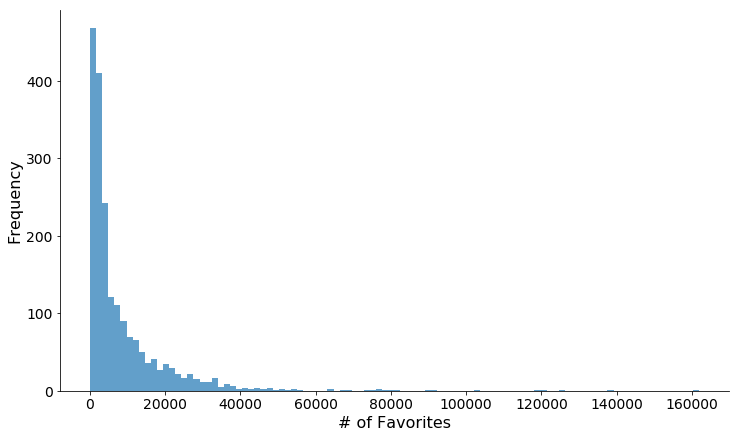

In [116]:
plot_hist_favorites()

* It turns out that the distribution of favorites is highly skewed to the right.
* Plotting the favorites distribution on a log scale may be more useful. Let's try that.

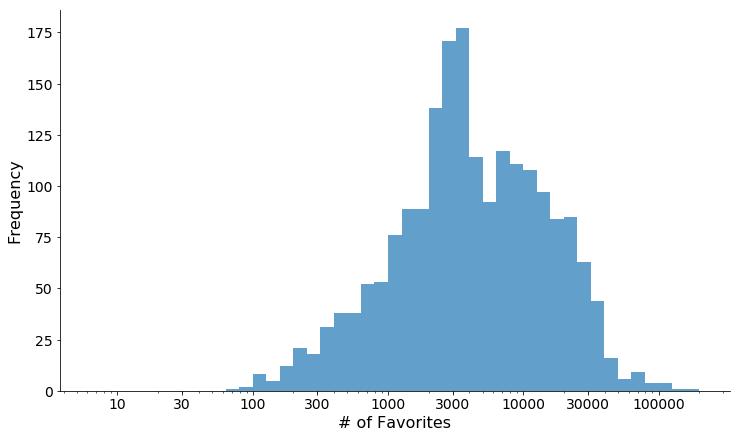

In [117]:
plot_hist_logFavorites()

* Now we're getting somewhere. It appears that the # of favorites roughly follows a log-normal distribution, albeit one that is skewed to the left and appears to be slightly bi-modal.
* In fact, the favorites distribution is NOT log-normal, but describing it as (roughly) log-normal is much more accurate than treating the # of favorites distribution as though it is a normal distribution.
* Bimodality:
  * The most frequent # of favorites seems to be ~3000, with a second cluster of tweets that tend to have ~10000 favorites
  * Let's add a density plot to the histogram to better visualize the (likely) bi-modality

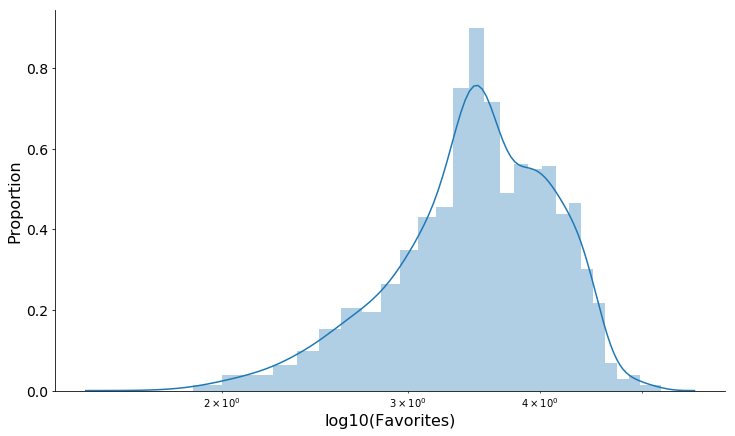

In [118]:
plot_hist_logFavorites_density()

* The kernal density estimation does indicate some slight bi-modality. This may be an indicator of how viral a particular tweet becomes:
  * Whereas many tweets may be favorited primarily by twitter users that follow @dog_rates (and thereby garner ~3000 favorites), other tweets may be favorited by communities and users outside of the "typical" @dog_rates followers (and thereby garner ~10000 favorites)
  * Additional analysis of **who** is favoriting various tweets could be interesting and applicable here. However, that is beyond the current scope of this project.<br><br>

* Truly **viral** tweets will have a high number of favorites, but be much less common. These tweets comprise the right tail of the distribution.<br><br>
    
* NOTE:
  * The line above is a kernal density estimation and represents the likely statistical distribution
  * Here is an interesting article on [Stacking Multiple Histograms Using Seaborn and Density Plots](https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0)

<a id='analysis_favorite_count_vs_time'></a>
([Top of Page](#top_of_page))

### Favorites vs. Time

Now that we've looked at the favorites distribution, let's see how it changes over time.

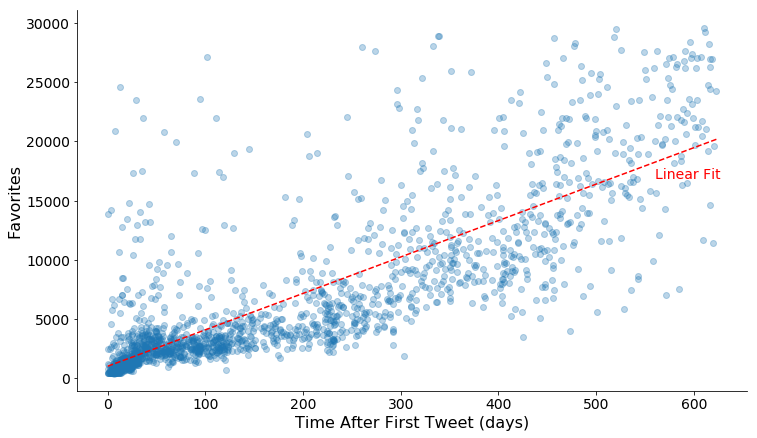

In [119]:
plot_favorites_vs_time()

* This is interesting. Clearly, the number of favorites that @dog_rates tweets receive has increased over time.
* It also appears that distribution of favorites seems to change over time
  * Whereas a majority of tweets in the first ~120 days have less than 5000 favorites, later tweets have a much more even distribution
  * This indicates that explicitly plotting the favorites distribution vs time may provide interesting insights.
    * A faceted or ridgeline plot may be useful for such a visualization.
    * That is considered outside of the current project scope, however. So I am noting it here as a potential future step.

<a id='analysis_tweets_per_week'></a>
([Top of Page](#top_of_page))

### Tweets per week

Since the last plot showed a high density of tweets in the first ~120 days, let's plot the number of tweets vs time to better visualize this particular trend

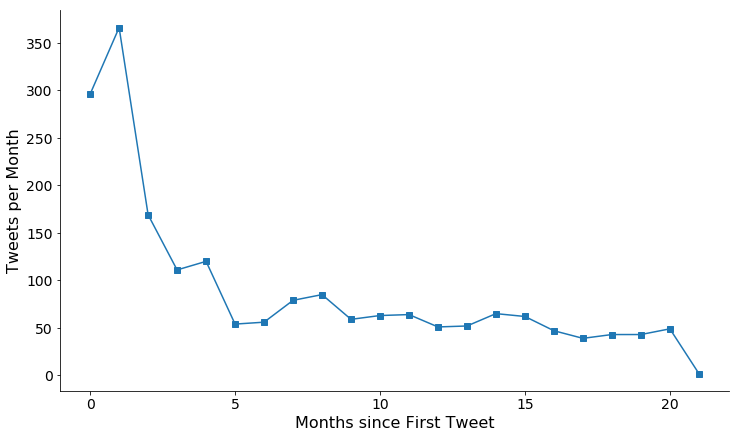

In [120]:
plot_tweets_per_week()

* As implied by the previous plot, the number of tweets did indeed decrease after the first few months.<br><br>
* Potential future analyses (not performed now for scope reasons):
  * It could be interesting to analyze other pieces of data to try and determine if there are any underlying reasons for the decrease. For instance:
    * It may be a natural characteristic of new twitter accounts
    * It may be a natural characteristic of _highly successful_ twitter accounts
    * It may correspond with @dog_rates transforming from a hobby to a brand and business
  * Other time-based analyses may also be of interest, such as:
    * Is there a day of the week or time of a given day that @dog_rates posts more often?
    * Is there a day of the week or time of a given day that corresponds to a tweet receiving more likes?

<a id='analysis_tweets_grouped_by_breed'></a>
([Top of Page](#top_of_page))

### Tweets vs. Breed Type

Last, but not least, let's do a quick exploration of whether some dog breeds are tweeted more than others.

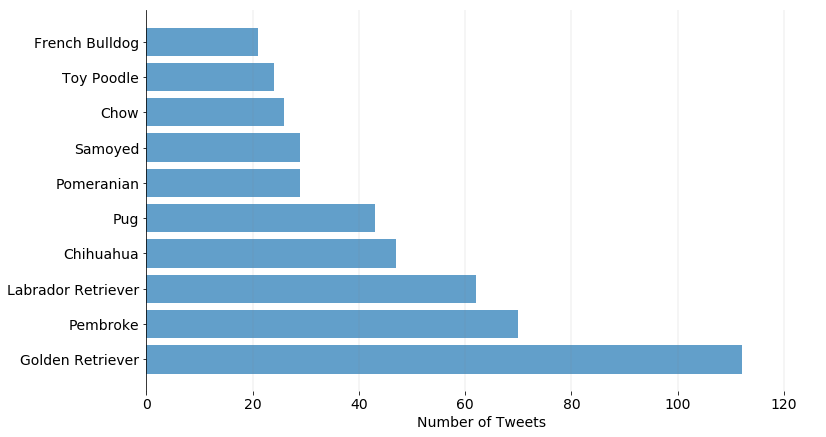

In [121]:
plot_tweets_vs_breedType()

* This indicates that images of Golden Retrievers are tweeted more than other breeds, with Pembrokes and Labrador Retrievers being second and third, respectively.
* It is worth noting that the above plot is based on the breeds identified by the neural network analysis with > 50% confidence. As such, the plot is reliant upon the accuracy of the prior neural network analysis.<br><br>

* Regarding potential future analysis, there are many ways that this could information could be further dissected, such as:
  * Are some breeds more popular in Country A than in Country B?
      * _NOTE_: this would require extracting additional location data via the Twitter API
  * Do the trends of most tweeted breeds still hold when considering tweets with less than 50% confidence in the identified breed?
  * Have some breeds become more or less popular over time?

<a id='cleaned_summary_final'></a>
([Top of Page](#top_of_page))

## Final List of Issues That Were Defined/Cleaned/Tested

**Ultimately, the following issues were defined, cleaned, and verification tested:**
* **Quality:**
  * Different number of records in the (initial) dataframes
  * Incorrectly high numerator values
  * Numerators with decimal points were rounded up
  * Tweets with incorrect numerator and denominator pairs were corrected
  * i.e., tweets with multiple fractions in the tweet text and had the wrong numerator and denominator values assigned when ratings were parsed
  * Numerators and denominators with zero values
  * ‘timestamp’ and 'retweeted_status_timestamp' changed to type ‘datetime'
  * changed the following columns to type 'int64':
    * 'in_reply_to_status_id'
    * 'in_reply_to_user_id',
    * 'retweeted_status_id'
    * 'retweeted_status_user_id'
  * Removed retweets
  * Converted ‘tweet_id’ to type int64 for consistency across dataframes
    * NOTE: converting all ‘tweet_id’ values to type string would have also been valid
  * Added a 'none' column to df_archive for tweets that do not have a dog stage
* **Tidiness:**
  * dropped columns 'retweeted_status_id', 'retweeted_status_user_id', and ‘retweeted_status_timestamp'
  * combined ‘doggo', 'floofer', 'pupper', and 'puppo' columns into a single column
    * (since they represent different categories of the same variable)
  * extracted url’s from the ‘text’ field
  * merged the ‘df_archive’ and ‘df_tweetInfo’ (i.e., the dataframe with JSON data) dataframes into a single dataframe
  * In ‘df_master’ and ‘df_images’, kept only those tweet_ids that were common to both df’s

<a id='potential_future_work'></a>
([Top of Page](#top_of_page))

## Potential Future Work

* This analysis could become vastly more interesting by performing more extensive feature engineering. Many of the variables contain a lot of information (for instance, ‘text’, ’timestamp’, or ‘name’) or could be confined with each other to create new information.<br><br>

* There also numerous additional analyses and visualizations that could be still be created. For more info on these view the accompanying external article, 'act_report.pdf' or review the [Analysis & Visualizations](#analysis_visualizations) section of this notebook.<br><br>

* Last, but not least, some potential data issues probably still exist, such as:
  * There may be some entries that are not pictures of dogs
  * In ‘df_master’, invalid dog names, such as ‘a’, ‘an’, ‘the’, etc.
  * In ‘df_images’, checking whether the # of tweets with a .jpg_url matches the total # of tweets in the df
  * the existence of records that include a picture and a dog name but do not actually have a picture of a dog